## Preprocess
This section performs preprocessing on the ATAC-seq data. Steps include quality control, cell aggregation, normalization, and log transformation.

In [23]:
import scanpy as sc
import os
import subprocess
import sys
from src.data.atac_preprocess import quality_control
from src.data.atac_preprocess import deepen_atac_data

In [ ]:
# NOTE: adata.var must contain the columns '#Chromosome', 'hg38_Start', and 'hg38_End'.
ATAC_FILE_PATH = "sample_data/PBMC169K"
sample_file = "atac_pbmc_benchmark_VIB_10xv1_1.h5ad"
adata = sc.read_h5ad(os.path.join(ATAC_FILE_PATH, sample_file))
adata.var['hg38_Start'] = adata.var['hg38_Start'].astype(int)
adata.var['hg38_End'] = adata.var['hg38_End'].astype(int)

In [ ]:
ATAC_FILE_PATH = "sample_data/PBMC169K"
sample_file = "atac_pbmc_benchmark_VIB_10xv1_1.h5ad"
adata = sc.read_h5ad(os.path.join(ATAC_FILE_PATH, sample_file))
adata.var['hg38_Start'] = adata.var['hg38_Start'].astype(int)
adata.var['hg38_End'] = adata.var['hg38_End'].astype(int)

In [28]:
# Preprocessing parameters for quality control and data aggregation
# - min_features: Minimum number of features (peaks) required per cell
# - max_features: Maximum number of features allowed per cell
# - min_percent: Minimum percentage of cells expressing a feature
# - cell_type_col: Column name for cell type annotation
# - num_cell_merge: Number of cells to merge during cell aggregation
data_args = {
    "min_features": 650,
    "max_features": 16500,
    "min_percent": 0.01,
    "cell_type_col": "celltype",
    "num_cell_merge": 10
}
preprocess_data_path = os.path.join(ATAC_FILE_PATH, f'{sample_file.split(".h5ad")[0]}_qc_deepen_norm_log.h5ad')

In [29]:
# quality control
print(f"Before quality control: {adata.shape}")
adata = quality_control(
    adata,
    min_features=data_args.get("min_features"),
    max_features=data_args.get("max_features"),
    min_percent=data_args.get("min_percent"),
    cell_type_col=data_args.get("cell_type_col", "cell type")
)
print(f"After quality control: {adata.shape}")
# cell aggregation
adata = deepen_atac_data(adata, num_cell_merge=10)
# normalize and log1p
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# write file
adata.write_h5ad(preprocess_data_path)

Before quality control: (2763, 411835)


After quality control: (2595, 264533)


## run inference
This section runs inference using a pretrained chromatin foundation model. The embeddings for cells are generated and saved to the specified output path.

In [30]:
# Configuration for running cell embedding inference
# - pretrain_checkpoint_path: Directory containing the pretrained model checkpoint
# - pretrain_model_name: File name of the pretrained model
# - pretrain_config_file: Configuration file used for model architecture and settings
# - batch_size: Batch size for inference
# - device: GPU device ID for computation
# - output_path: Directory to save the inferred cell embeddings
inference_config = {
    "pretrain_checkpoint_path": "checkpoints",
    "pretrain_model_name": "model.pt",
    "pretrain_config_file": "chromfd_pretrain.yaml",
    "batch_size": 16,
    "device": 1,
    "output_path": str(os.path.join(ATAC_FILE_PATH, "cell_embedding"))
}

In [31]:
train_command = [
    sys.executable, '-m', 'src.cell_embedding',
    '--local_rank', f'{inference_config["device"]}',
    '--data_path', preprocess_data_path,
    '--output_path', inference_config['output_path'],
    '--pretrain_checkpoint_path', inference_config['pretrain_checkpoint_path'],
    '--pretrain_model_file', inference_config['pretrain_model_name'],
    '--pretrain_config_file', inference_config['pretrain_config_file'],
    '--batch_size', f'{inference_config["batch_size"]}',
    '--cell_type_col', data_args["cell_type_col"]
]

subprocess.run(train_command)

INFO:root:Reading h5ad file from sample_data/PBMC169K/atac_pbmc_benchmark_VIB_10xv1_1_qc_deepen_norm_log.h5ad
100%|██████████| 163/163 [09:55<00:00,  3.65s/it]
INFO:root:make directory sample_data/PBMC169K/cell_embedding
INFO:root:Embeddings shape: (2595, 264533) saved to sample_data/PBMC169K/cell_embedding


CompletedProcess(args=['/cpfs01/projects-HDD/cfff-c7cd658afc74_HDD/jiaoyifeng/miniconda3/envs/scgpt_env/bin/python', '-m', 'src.cell_embedding', '--local_rank', '1', '--data_path', 'sample_data/PBMC169K/atac_pbmc_benchmark_VIB_10xv1_1_qc_deepen_norm_log.h5ad', '--output_path', 'sample_data/PBMC169K/cell_embedding', '--pretrain_checkpoint_path', 'checkpoints', '--pretrain_model_file', 'model.pt', '--pretrain_config_file', 'chromfd_pretrain.yaml', '--batch_size', '16', '--cell_type_col', 'celltype'], returncode=0)

## metric
This section evaluates the quality of the generated embeddings. It uses clustering metrics such as ARI, NMI, AMI, and FMI to assess performance.

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
def calculate_cluster(mat_in, true_label, random_state=23):
    num_label = len(np.unique(true_label))
    kmeans = KMeans(n_clusters=num_label, random_state=random_state).fit(mat_in)
    return kmeans.labels_

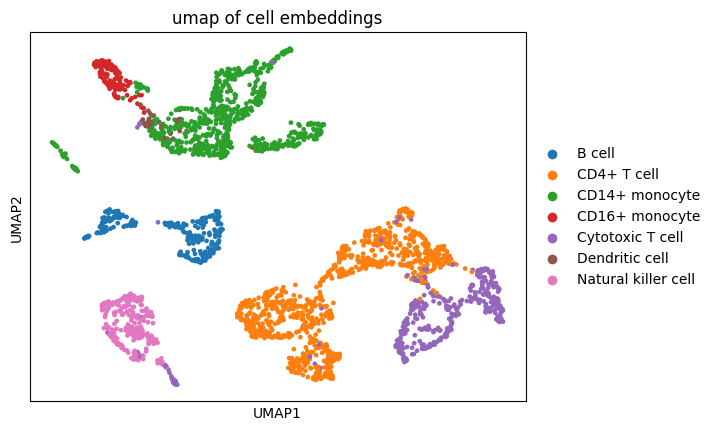

In [35]:
adata = sc.read_h5ad(os.path.join(ATAC_FILE_PATH, "cell_embedding", "embeddings.h5ad"))
obs_df = pd.DataFrame(adata.obs['celltype'].tolist(), columns=['celltype'])
adata = sc.AnnData(X=adata.obsm['X_embedding'], obs=obs_df)
sc.tl.pca(adata, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype', title='umap of cell embeddings')

In [45]:
cluster_label = calculate_cluster(adata.obsm['X_pca'], adata.obs["celltype"])
ari_norm = adjusted_rand_score(adata.obs["celltype"], cluster_label)
nmi = normalized_mutual_info_score(adata.obs["celltype"], cluster_label)
ami = adjusted_mutual_info_score(adata.obs["celltype"], cluster_label)
fmi = fowlkes_mallows_score(adata.obs["celltype"], cluster_label)
print(
    f"ari: {ari_norm}, "
    f"nmi: {nmi}, "
    f"ami: {ami}, "
    f"fmi: {fmi}"
)

ari: 0.7573429535020857, nmi: 0.842267548775634, ami: 0.8416228114166705, fmi: 0.811748902937001
